### MRI BRAIN TUMOR SEGMENTATION CLASSIFIER
#### Author: Jacob Heyman
***


## Overview

### Business Problem


### Data Understanding


#### Import packages

In [98]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, shutil
import numpy as np
from math import ceil
import itertools
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, f1_score
from skimage.feature import hog
from skimage import exposure
np.random.seed(123)

import keras
from keras import models
from keras import layers
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam, SGD
from keras.metrics import Recall, Precision 
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow as tf

### Read in Image Data with datagenorator

In [2]:
directory = 'mri_data'
train_directory = 'mri_data/Training'
test_directory = 'mri_data/Testing'

In [3]:
data_train = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 2870, 
        seed = 123)

# separate images from labels
train_images, train_labels = next(data_train)
print('Found Classes: ',data_train.class_indices)

Found 2870 images belonging to 4 classes.
Found Classes:  {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


### Check distribution of Classes

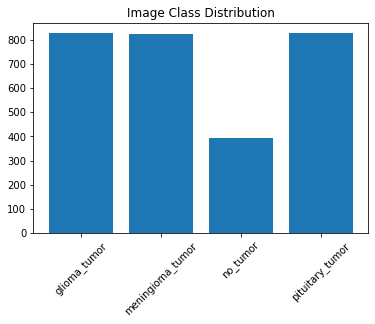

In [4]:
plt.bar(['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor'], sum(train_labels))
plt.xticks(rotation=45)
plt.title('Image Class Distribution');
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('./images/class_balance.png')

### Display assortment of different classes

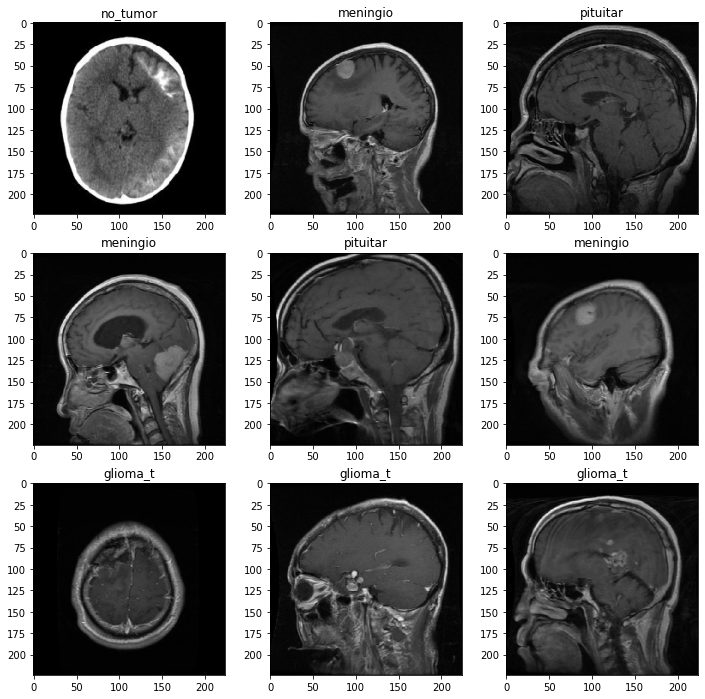

In [5]:
def get_label(array):
    """
    Returns String Label of Class
    """
    if array[0] ==1:
        return 'glioma_tumor'
    elif array[1] ==1:
        return 'meningioma_tumor'
    elif array[2] ==1:
        return 'no_tumor'
    elif array[3] ==1:
        return 'pituitary_tumor'

label_names = np.apply_along_axis(get_label,1,train_labels)

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))

for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(train_images[i])
  plt.gca().set_title(label_names[i])
plt.show()

### Seperate images by class for EDA

In [6]:
#isolated milddemented class images for eda
data_glioma = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 717, 
        seed = 123,
        classes= ['glioma_tumor'])

data_meningioma = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 52, 
        seed = 123,
        classes= ['meningioma_tumor'])

data_no_tumor = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 2560, 
        seed = 123,
        classes= ['no_tumor'])

data_pituitary = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 1792, 
        seed = 123,
        classes= ['pituitary_tumor'])

glioma_images, glioma_labels = next(data_glioma)
meningioma_images, meningioma_labels = next(data_meningioma)
no_tumor_images, no_tumor_labels = next(data_no_tumor)
pituitary_images, pituitary_labels = next(data_pituitary)

Found 826 images belonging to 1 classes.
Found 822 images belonging to 1 classes.
Found 395 images belonging to 1 classes.
Found 827 images belonging to 1 classes.


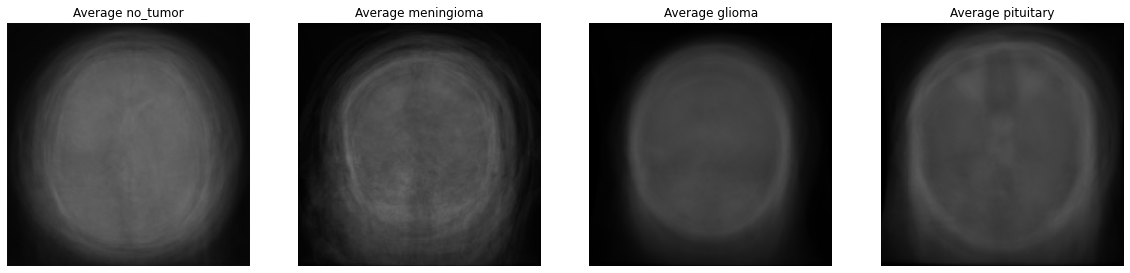

In [7]:
def find_mean_img(full_mat, ax, title, size = (224, 224)):
    """
    Returns mean images given array of images
    """
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    #mean_img = mean_img.reshape(size)
    ax.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    ax.set_title(f'Average {title}')
    ax.axis('off')
    return mean_img

fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(20,5))

No_tumor_mean = find_mean_img(no_tumor_images, ax[0], 'no_tumor')
meningioma_images_mean = find_mean_img(meningioma_images, ax[1],  'meningioma')
glioma_images_mean = find_mean_img(glioma_images,  ax[2], 'glioma')
pituitary_images_mean = find_mean_img(pituitary_images,  ax[3], 'pituitary')

plt.savefig('./images/mean.png')

### Function for 9x9 image display by catagory

In [8]:
def image_subplot(catagory,title):

    plt.figure(figsize=(12,12))

    for i in range(9):
      plt.subplot(330 + 1 + i)
      plt.imshow(catagory[i])
      plt.gca().set_title(title)
    return plt.show()

### Display images for each catagory
- Glioma Tumors

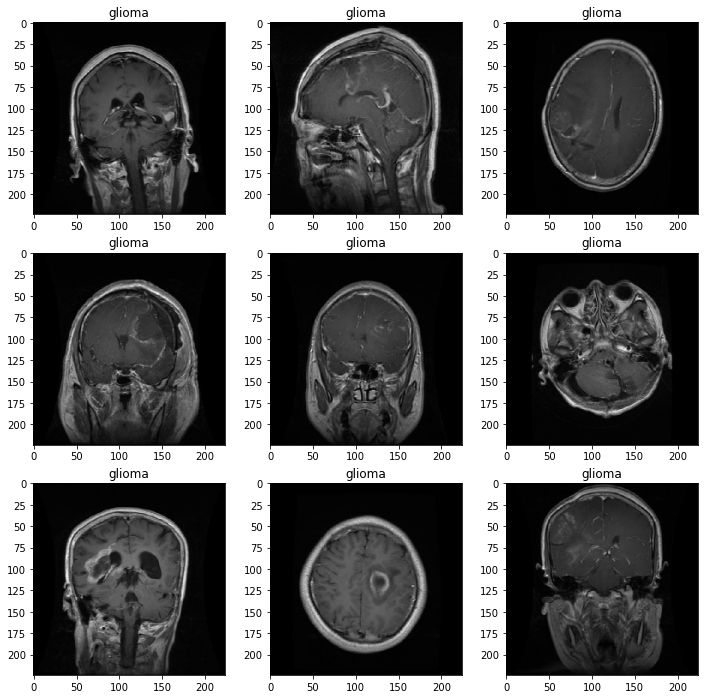

In [9]:
image_subplot(glioma_images,'glioma')

- no tumors

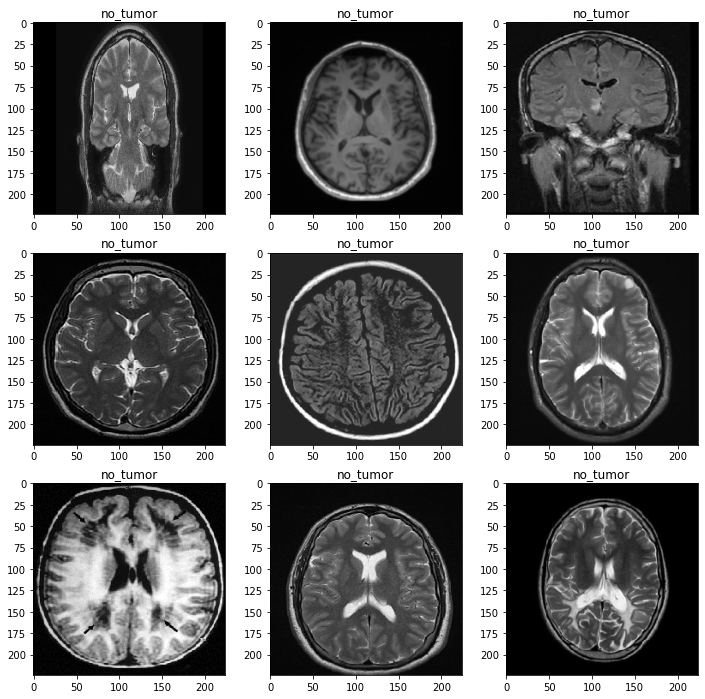

In [10]:
image_subplot(no_tumor_images,'no_tumor')

- Meningioma Tumors

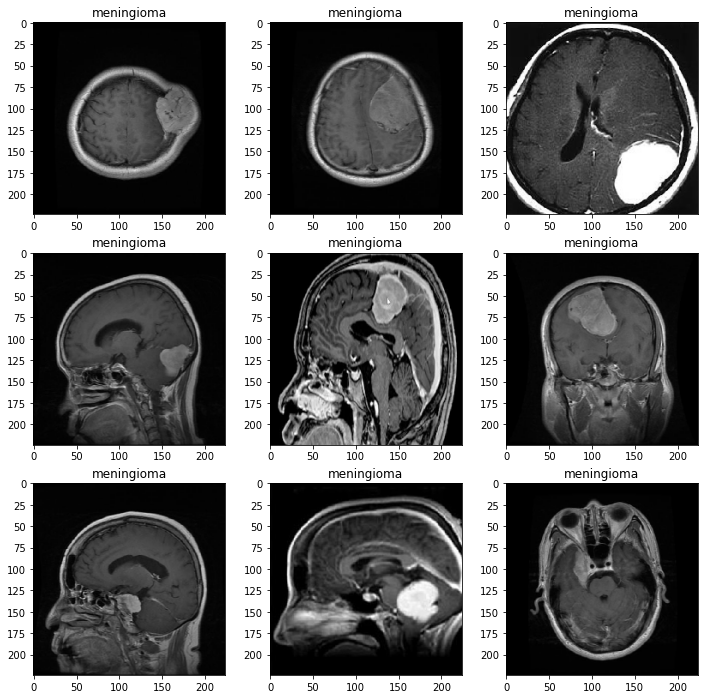

In [11]:
image_subplot(meningioma_images,'meningioma')

- Pituritary Tumors

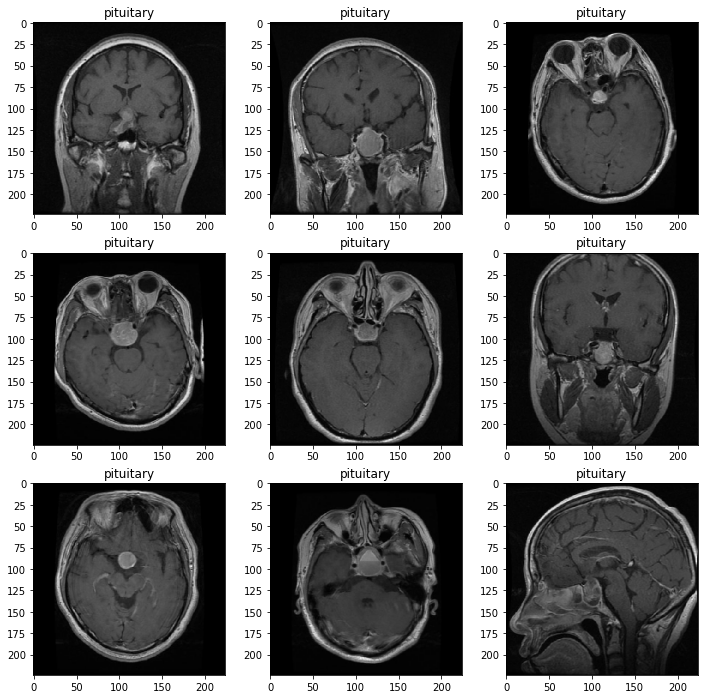

In [210]:
image_subplot(pituitary_images,'pituitary')

### Create validation set for modeling process

In [213]:
data_genorator = ImageDataGenerator(rescale=1./255,validation_split=0.2)

data_train= data_genorator.flow_from_directory( 
        train_directory, 
        subset= 'training',
        target_size=(224, 224), 
        batch_size = 4098, 
        seed = 123)

data_valid = data_genorator.flow_from_directory( 
        train_directory, 
        subset= 'validation',
        target_size=(224, 224), 
        batch_size = 1023, 
        seed = 123)

data_test= ImageDataGenerator(rescale=1./255).flow_from_directory( 
        test_directory, 
        target_size=(224, 224), 
        batch_size = 1279, 
        seed = 123)

train_images, train_labels = next(data_train)

test_images, test_labels = next(data_test)

valid_images, valid_labels = next(data_valid)

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


### Image Augmentation to fix class imbalance

Used imagedatagenorator to horizontil flip images and concatenate them into the train image dataset


In [211]:
hflip = ImageDataGenerator(rescale=1./255,horizontal_flip=True)

no_tumor_aug = hflip.flow_from_directory(train_directory,
                                        target_size=(224,224),
                                        batch_size = 395,
                                        seed = 123,
                                        classes= ['no_tumor'])





Found 395 images belonging to 1 classes.


In [15]:
no_tumor_images_aug, no_tumor_images_labels = next(no_tumor_aug)

In [16]:
no_tumor_images_aug.shape

(395, 224, 224, 3)

In [17]:
no_tumor_images_labels.shape

(395, 1)

#### augmented no tumor images

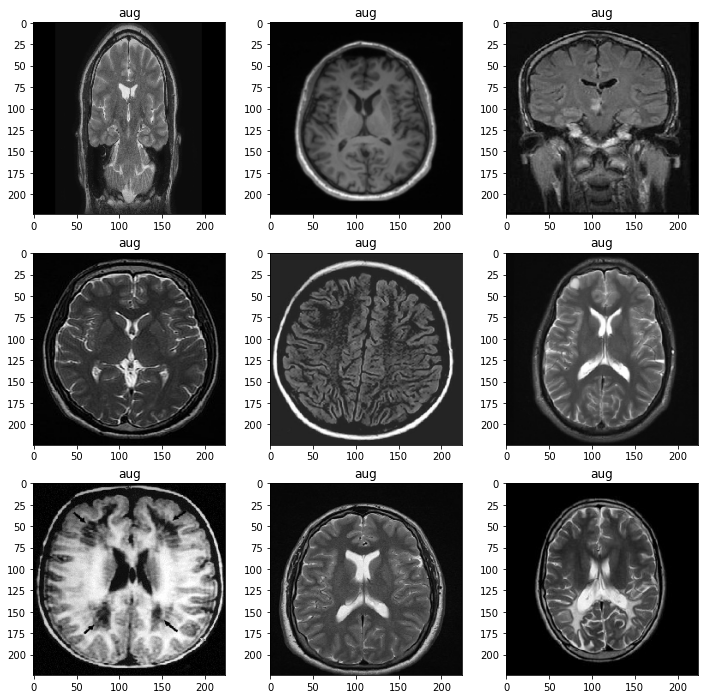

In [18]:
image_subplot(no_tumor_images_aug,'aug')

In [19]:
concat_notumor_images = np.vstack(no_tumor_images_aug)

In [30]:
concat_notumor_labels = np.array([[0.,0.,1.,0.] for i in range(len(no_tumor_images))])

In [36]:
concat_notumor_labels.shape

(395, 4)

In [35]:
train_labels.shape

(2297, 4)

In [33]:
train_images_aug = np.concatenate((train_images,no_tumor_images_aug))
train_labels_aug = np.concatenate((train_labels,concat_notumor_labels))

In [170]:
train_images_aug.shape

(2692, 224, 224, 3)

In [23]:
train_images.shape

(2297, 224, 224, 3)

#### Class distribution after augmented data was added to no tumor class

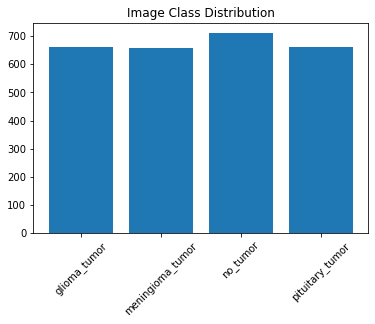

In [37]:
plt.bar(['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor'], sum(train_labels_aug))
plt.xticks(rotation=45)
plt.title('Image Class Distribution');
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('./images/class_balance.png')

### Double the dataset with augmented data

- Try to address missclassification of glioma and pituitary tumors by adding augmented data to all image classes.

In [228]:
train_aug = hflip.flow_from_directory(train_directory,
                                        target_size=(224,224),
                                        batch_size = 2297,
                                        seed = 123,
                                        classes = ['no_tumor','glioma_tumor','meningioma_tumor','pituitary_tumor'])
train_aug_images, train_aug_labels = next(train_aug)



print('Found Classes: ',train_aug.class_indices)

Found 2870 images belonging to 4 classes.
Found Classes:  {'no_tumor': 0, 'glioma_tumor': 1, 'meningioma_tumor': 2, 'pituitary_tumor': 3}


In [226]:
train_aug_labels.shape

(2297, 1)

In [227]:
print(train_aug_labels[0])

[0.]


In [225]:
train_aug_labels = np.reshape(train_aug_labels[:,0],(2297,1))

In [191]:
train_images.shape

(2297, 224, 224, 3)

In [209]:
train_aug_images.shape

(2297, 224, 224, 3)

In [229]:
tain_total_aug_images = np.concatenate((train_images,train_aug_images))
train_total_aug_labels = np.concatenate((train_labels,train_aug_labels))

In [232]:
train_total_aug_images = np.concatenate((train_images,train_aug_images))
print(train_total_aug_images.shape)

(4594, 224, 224, 3)


In [230]:
train_total_aug_labels.shape

(4594, 4)

In [231]:
train_total_aug_images.shape

(4989, 4)

### Function for confusion matrix evaluation of CNN

In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

###  Baseline simple CNN
simple cnn with two convolutional layers with a 3x3 filter and maxpooling.  One dense layer with 32 neurons and an activation layer with softmax for catagorical classification.  

In [44]:
batch_size = 50
num_classes = 4
epochs = 30
np.random.seed(7)

#model architecture
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  3),use_bias=True))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu',use_bias=True))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(4, activation='softmax'))

cnn.summary()

cnn.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=[Recall(),'accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto')


history_baseline = cnn.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [early_stop],
                    validation_data=(valid_images, valid_labels))
score = cnn.evaluate(test_images, test_labels, verbose=0)
print('test loss:', score[0])
print('Test recall:', score[1])
print('Test Accuracy', score[2])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 109, 109, 32)      18464     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 93312)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2986016   
_________________________________________________________________
dense_9 (Dense)              (None, 4)                

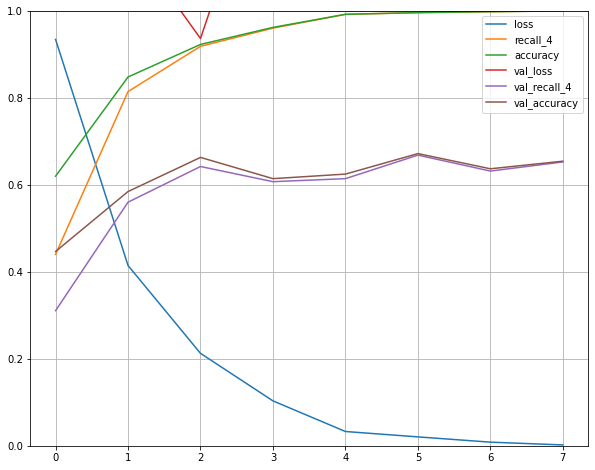

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Normalized confusion matrix
[[0.17       0.34       0.4        0.09      ]
 [0.         0.99130435 0.00869565 0.        ]
 [0.         0.03809524 0.95238095 0.00952381]
 [0.01351351 0.47297297 0.12162162 0.39189189]]


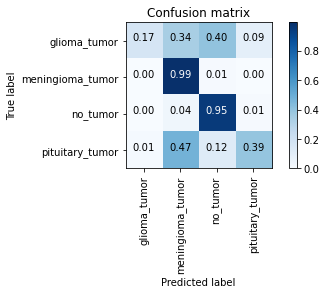

In [47]:
history_baseline_df = pd.DataFrame(history_baseline.history)
history_baseline_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

y_pred = cnn.predict_classes(test_images)

confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices, normalize=True)

### baseline with class imbalance augmented dataset

In [48]:
batch_size = 50
num_classes = 4
epochs = 30
np.random.seed(7)

#model architecture
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  3),use_bias=True))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu',use_bias=True))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(4, activation='softmax'))

cnn.summary()

cnn.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=[Recall(),'accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto')


history_basline_aug = cnn.fit(train_images_aug, train_labels_aug,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [early_stop],
                    validation_data=(valid_images, valid_labels))
score = cnn.evaluate(test_images, test_labels, verbose=0)
print('test loss:', score[0])
print('Test recall:', score[1])
print('Test Accuracy', score[2])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 109, 109, 32)      18464     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 93312)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2986016   
_________________________________________________________________
dense_11 (Dense)             (None, 4)                

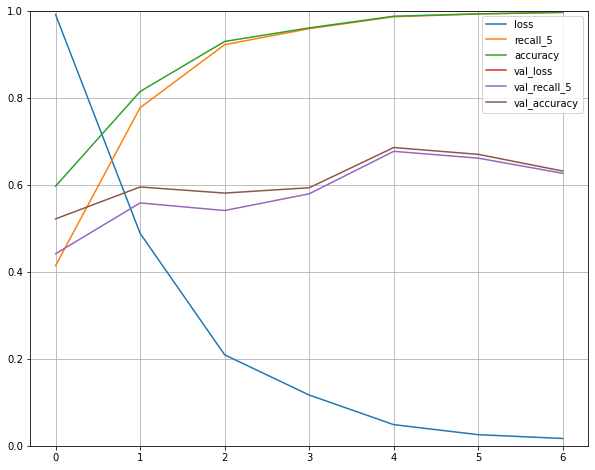

Normalized confusion matrix
[[0.17       0.18       0.61       0.04      ]
 [0.         0.95652174 0.04347826 0.        ]
 [0.         0.02857143 0.97142857 0.        ]
 [0.01351351 0.28378378 0.2972973  0.40540541]]


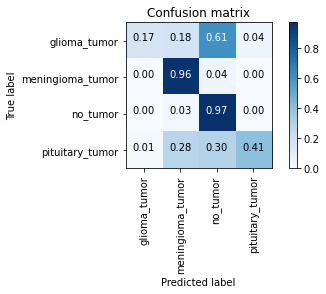

In [50]:
history_baseline_df = pd.DataFrame(history_basline_aug.history)
history_baseline_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

y_pred = cnn.predict_classes(test_images)

confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices, normalize=True)

### experimental CNN #1
3 convolutinal layers with batch normilization and max pooling for the first layer and average pooling in the subsequent layes.  Layer filters descend from 16X16 to 8X8 to 3X3.  Two dense layers of 1032 neurons and an activation output layer with softmax for classification of the 4 classes. 

In [106]:
batch_size = 50
num_classes = 4
epochs = 30
np.random.seed(7)

#model architecture
exp1_cnn = models.Sequential()
exp1_cnn.add(layers.Conv2D(64, (16, 16), activation='relu', input_shape=(224, 224,  3),use_bias=True))
exp1_cnn.add(keras.layers.BatchNormalization())
exp1_cnn.add(layers.MaxPooling2D((2, 2)))
exp1_cnn.add(layers.Conv2D(64, (8, 8), activation='relu', input_shape=(224, 224,  3),use_bias=True))
exp1_cnn.add(keras.layers.BatchNormalization())
exp1_cnn.add(layers.AveragePooling2D((2, 2)))
exp1_cnn.add(layers.Conv2D(32, (3, 3), activation='relu',use_bias=True))
exp1_cnn.add(keras.layers.BatchNormalization())
exp1_cnn.add(layers.AveragePooling2D((2, 2)))
exp1_cnn.add(layers.Flatten())
exp1_cnn.add(layers.Dense(1032, activation='relu'))
exp1_cnn.add(layers.Dense(1032, activation='relu'))
exp1_cnn.add(layers.Dense(4, activation='softmax'))

exp1_cnn.summary()

exp1_cnn.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=[Recall(),'accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto')


history_exp1_cnn = exp1_cnn.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [early_stop],
                    validation_data=(valid_images, valid_labels))
score = exp1_cnn.evaluate(test_images, test_labels, verbose=0)
print('test loss:', score[0])
print('Test recall:', score[1])
print('Test Accuracy', score[2])

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           (None, 209, 209, 64)      49216     
_________________________________________________________________
batch_normalization_30 (Batc (None, 209, 209, 64)      256       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 104, 104, 64)      0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 97, 97, 64)        262208    
_________________________________________________________________
batch_normalization_31 (Batc (None, 97, 97, 64)        256       
_________________________________________________________________
average_pooling2d_3 (Average (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 46, 46, 32)      

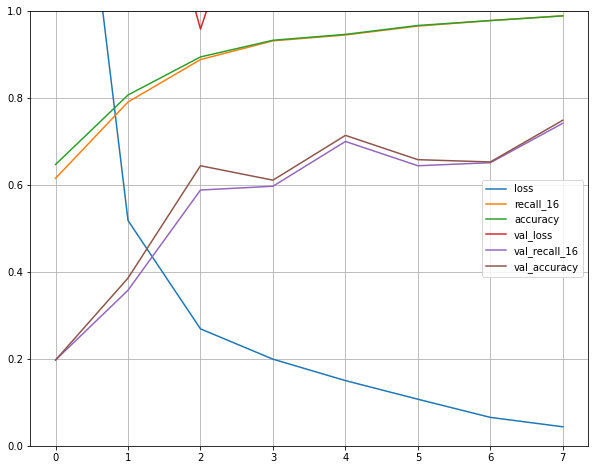

Normalized confusion matrix
[[0.2        0.21       0.38       0.21      ]
 [0.00869565 0.92173913 0.0173913  0.05217391]
 [0.01904762 0.02857143 0.94285714 0.00952381]
 [0.13513514 0.05405405 0.12162162 0.68918919]]


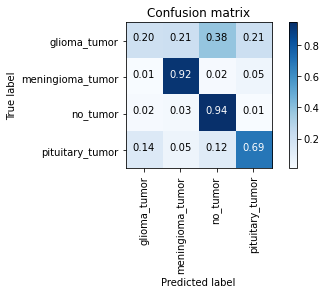

In [108]:
history_baseline_df = pd.DataFrame(history_exp1_cnn.history)
history_baseline_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

y_pred = exp1_cnn.predict_classes(test_images)

confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices, normalize=True)

### exp1 cnn with classimbalance aug dataset

In [122]:
batch_size = 50
num_classes = 4
epochs = 30
#np.random.seed(15)

#model architecture
exp1_cnn = models.Sequential()
exp1_cnn.add(layers.Conv2D(64, (6, 6), activation='relu', input_shape=(224, 224,  3),use_bias=True, padding='Same'))
exp1_cnn.add(layers.MaxPooling2D((2, 2),strides=(2,2)))
exp1_cnn.add(Dropout(0.2))
exp1_cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  3),use_bias=True,padding='Same'))
exp1_cnn.add(layers.MaxPooling2D((2, 2),strides=(2,2)))
exp1_cnn.add(Dropout(0.2))
exp1_cnn.add(layers.Conv2D(32, (3, 3), activation='relu',use_bias=True,padding='Same'))
exp1_cnn.add(layers.MaxPooling2D((2, 2),strides=(2,2)))
exp1_cnn.add(Dropout(0.2))
exp1_cnn.add(layers.Conv2D(32, (2, 2), activation='relu',use_bias=True,padding='Same'))
exp1_cnn.add(layers.MaxPooling2D((2, 2),strides=(2,2)))
exp1_cnn.add(Dropout(0.2))

exp1_cnn.add(layers.Flatten())

exp1_cnn.add(layers.Dense(1032, activation='relu'))
exp1_cnn.add(Dropout(0.5))
exp1_cnn.add(layers.Dense(4, activation='softmax'))

exp1_cnn.summary()

exp1_cnn.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=[Recall(),'accuracy'])

early_stop = EarlyStopping(monitor='val_accuracy',patience=4,verbose=1,mode='max')


history_exp1_cnn = exp1_cnn.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [early_stop],
                    validation_data=(valid_images, valid_labels))
score = exp1_cnn.evaluate(test_images, test_labels, verbose=0)
print('test loss:', score[0])
print('Test recall:', score[1])
print('Test Accuracy', score[2])

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_115 (Conv2D)          (None, 224, 224, 64)      6976      
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 56, 56, 32)      

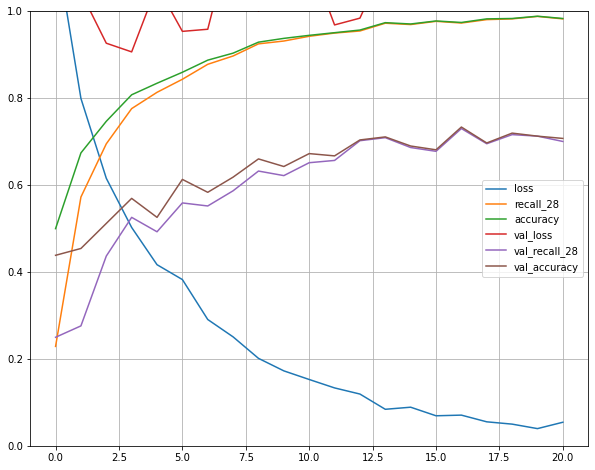

Normalized confusion matrix
[[0.18       0.18       0.6        0.04      ]
 [0.00869565 0.97391304 0.0173913  0.        ]
 [0.         0.04761905 0.95238095 0.        ]
 [0.02702703 0.37837838 0.12162162 0.47297297]]


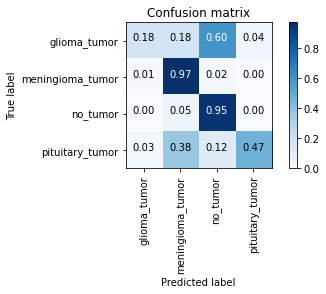

In [123]:
history_baseline_df = pd.DataFrame(history_exp1_cnn.history)
history_baseline_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

y_pred = exp1_cnn.predict_classes(test_images)

confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices, normalize=True)

### AlexNet

In [124]:
batch_size = 24
num_classes = 4
epochs = 30
np.random.seed(7)


alex_no_aug = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

alex_no_aug.summary()

alex_no_aug.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=[Recall(),'accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto')

alex_no_aug_history = alex_no_aug.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [early_stop],
                    validation_data=(valid_images, valid_labels))

score = alex_no_aug.evaluate(test_images, test_labels, verbose=0)

print('test loss:', score[0])
print('Test recall:', score[1])
print('Test Accuracy', score[2])

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_119 (Conv2D)          (None, 54, 54, 96)        34944     
_________________________________________________________________
batch_normalization_48 (Batc (None, 54, 54, 96)        384       
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 26, 26, 256)       614656    
_________________________________________________________________
batch_normalization_49 (Batc (None, 26, 26, 256)       1024      
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 12, 12, 384)     

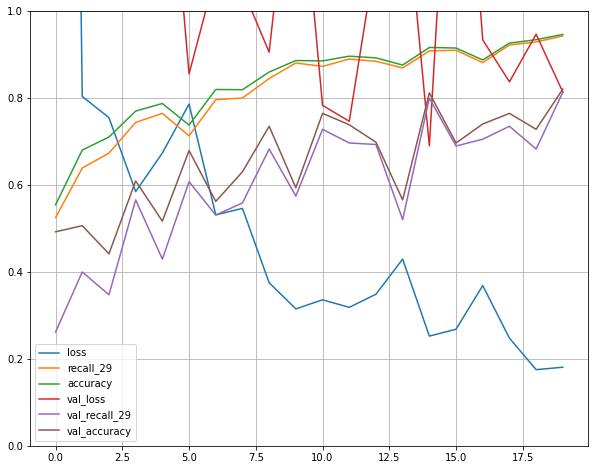

Normalized confusion matrix
[[0.2        0.3        0.4        0.1       ]
 [0.04347826 0.80869565 0.13043478 0.0173913 ]
 [0.02857143 0.00952381 0.96190476 0.        ]
 [0.04054054 0.31081081 0.31081081 0.33783784]]


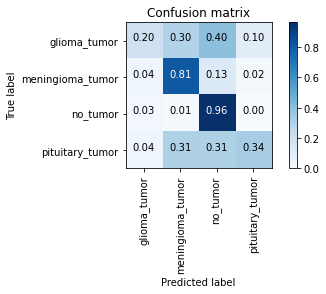

In [125]:
history_baseline_df = pd.DataFrame(alex_no_aug_history.history)
history_baseline_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

y_pred = alex_no_aug.predict_classes(test_images)

confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices, normalize=True)

### AlexNet with class imbalance aug

In [127]:
batch_size = 24
num_classes = 4
epochs = 30



alex = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

alex.summary()

alex.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=[Recall(),'accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto')

alex_history = alex.fit(train_images_aug, train_labels_aug,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [early_stop],
                    validation_data=(valid_images, valid_labels))

score = alex.evaluate(test_images, test_labels, verbose=0)

print('test loss:', score[0])
print('Test recall:', score[1])
print('Test Accuracy', score[2])

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_129 (Conv2D)          (None, 54, 54, 96)        34944     
_________________________________________________________________
batch_normalization_58 (Batc (None, 54, 54, 96)        384       
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 26, 26, 256)       614656    
_________________________________________________________________
batch_normalization_59 (Batc (None, 26, 26, 256)       1024      
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 12, 12, 384)     

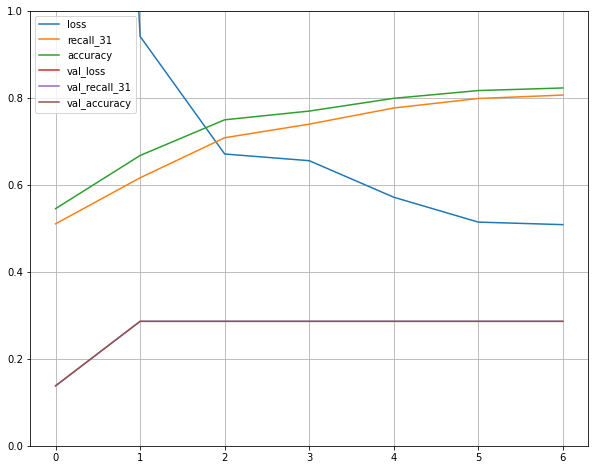

Normalized confusion matrix
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


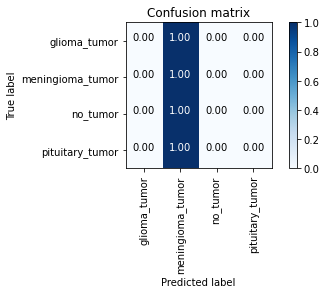

In [128]:
history_baseline_df = pd.DataFrame(alex_history.history)
history_baseline_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

y_pred = alex.predict_classes(test_images)

confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices, normalize=True)

KeyboardInterrupt: 

In [96]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam, SGD
from keras.metrics import Recall, Precision 
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv2D

### Experimental CNN 2 
4 convolutional layers all with maxppooling and dropout.  Filter size descends from 5X5 to two 3X3 and a final 2X2
two dense layers with 300 neurons and 50% dropout.  

In [214]:
batch_size = 50
num_classes = 4
epochs = 40
#np.random.seed(8)

model_1 = models.Sequential()

model_1.add(layers.Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(5,5),padding="same", activation="relu"))
model_1.add(layers.MaxPool2D(pool_size=(3,3),strides=(2,2)))
model_1.add(layers.Dropout(0.25))

model_1.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model_1.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model_1.add(layers.Dropout(0.25))

model_1.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model_1.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model_1.add(layers.Dropout(0.25))

model_1.add(layers.Conv2D(filters=512, kernel_size=(2,2), padding="same", activation="relu"))
model_1.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model_1.add(layers.Dropout(0.3))

#model.add(layers.Conv2D(filters=512, kernel_size=(2,2), padding="same", activation="relu"))
#model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
#model.add(layers.Dropout(0.3))

model_1.add(layers.Flatten())


model_1.add(layers.Dense(300, activation='relu'))
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(300, activation='relu'))
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(4, activation='softmax'))

model_1.summary()

model_1.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=[Recall(),'accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience=6,verbose=1,mode='auto')


history_exp2 = model_1.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [early_stop],
                    validation_data=(valid_images, valid_labels))
score = model_1.evaluate(test_images, test_labels, verbose=0)
print('test loss:', score[0])
print('Test recall:', score[1])
print('Test Accuracy', score[2])

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_265 (Conv2D)          (None, 224, 224, 64)      4864      
_________________________________________________________________
max_pooling2d_188 (MaxPoolin (None, 111, 111, 64)      0         
_________________________________________________________________
dropout_184 (Dropout)        (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_266 (Conv2D)          (None, 111, 111, 128)     73856     
_________________________________________________________________
max_pooling2d_189 (MaxPoolin (None, 55, 55, 128)       0         
_________________________________________________________________
dropout_185 (Dropout)        (None, 55, 55, 128)       0         
_________________________________________________________________
conv2d_267 (Conv2D)          (None, 55, 55, 256)     

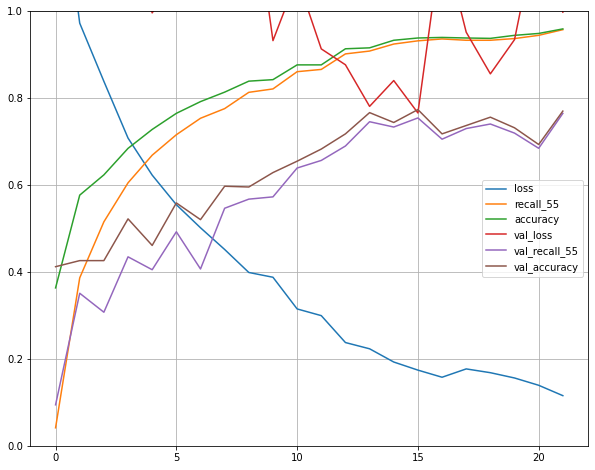

Normalized confusion matrix
[[0.18       0.3        0.47       0.05      ]
 [0.04347826 0.89565217 0.05217391 0.00869565]
 [0.02857143 0.03809524 0.93333333 0.        ]
 [0.02702703 0.33783784 0.14864865 0.48648649]]


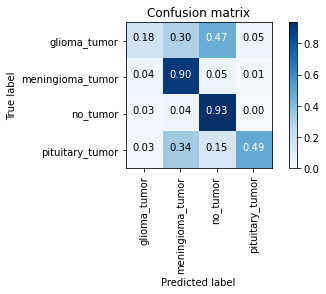

In [215]:
history_baseline_df = pd.DataFrame(history_exp2.history)
history_baseline_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

y_pred = model_1.predict_classes(test_images)

confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices, normalize=True)

In [ ]:
batch_size = 50
num_classes = 4
epochs = 40
#np.random.seed(8)

model = models.Sequential()

model.add(layers.Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(5,5),padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(3,3),strides=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(filters=512, kernel_size=(2,2), padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(layers.Dropout(0.3))

#model.add(layers.Conv2D(filters=512, kernel_size=(2,2), padding="same", activation="relu"))
#model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
#model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=[Recall(),'accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience=10,verbose=1,mode='auto')


history_vgg16 = model.fit(train_total_aug_images, train_total_aug_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [early_stop],
                    validation_data=(valid_images, valid_labels))
score = model.evaluate(test_images, test_labels, verbose=0)
print('test loss:', score[0])
print('Test recall:', score[1])
print('Test Accuracy', score[2])

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_285 (Conv2D)          (None, 224, 224, 64)      4864      
_________________________________________________________________
max_pooling2d_208 (MaxPoolin (None, 111, 111, 64)      0         
_________________________________________________________________
dropout_211 (Dropout)        (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_286 (Conv2D)          (None, 111, 111, 128)     73856     
_________________________________________________________________
max_pooling2d_209 (MaxPoolin (None, 55, 55, 128)       0         
_________________________________________________________________
dropout_212 (Dropout)        (None, 55, 55, 128)       0         
_________________________________________________________________
conv2d_287 (Conv2D)          (None, 55, 55, 256)     

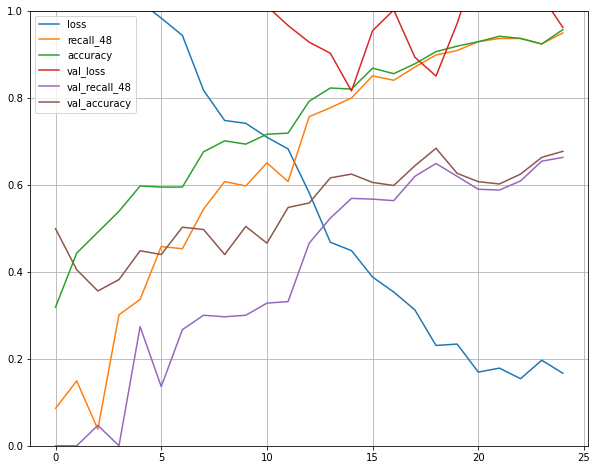

Normalized confusion matrix
[[0.21       0.36       0.3        0.13      ]
 [0.06956522 0.5826087  0.2        0.14782609]
 [0.04761905 0.22857143 0.57142857 0.15238095]
 [0.13513514 0.5        0.12162162 0.24324324]]


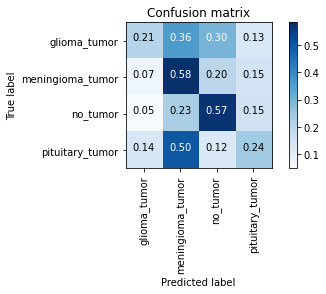

In [153]:
history_baseline_df = pd.DataFrame(history_vgg16.history)
history_baseline_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

y_pred = model.predict_classes(test_images)

confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices, normalize=True)